# Subcritical systems

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name='Jens'

# Subcritical systems

Subcritical systems can be a lot of fun, one reason for this is because measuring the k-effective is easier in such a system. Also because they are often a bit counterintuitive: we often think about subcriticality in terms of decreasing neutron population, but this is not the case if we we place a steady source in the system. It is advicable to read the lecture notes before starting the datalab. We will use this datalab to perform three experiments

1. How to measure the subcritical reactivity of a system? We will apply the Sjöstrand-method on some measured data.
2. How do we approach criticality with a reactor? We will perform the 1/M method.
3. Can we see the correlation of neutrons coming from the same fission? We will use the Rossi-alpha distribution to find this out.

And of course we are going to use python for this. We will sharpen our plotting skills, perform some numerical integration, and function fitting. Let's the fun begin!

## Experiment 1: Sjöstrand-method

Nils Göran Sjöstrand was one of the pioneers of reactor physics. He proposed an elegant method to measure the reactivity in subcritical reactors. His article from 1956, describing the area ratio method, is one of the most cited Swedish publications in reactor physics, and still today there is an interest in applying his work. The reason is the recent development of Accelerator Driven Systems envisoned to be able to reduce the lifetime of nuclear waste by transmuting it. Such systems are subcritical reactors driven by a strong neutron source. Thus being able to measure the subcritical reactivity is just as important for safety as it was nearly 70 years ago. (Further reading on Nils Göran Sjöstrand: https://www.chalmers.se/en/centres/snec/news/Pages/Nils-G%C3%B6ran-Sj%C3%B6strand-1925---2014.aspx)


The area method allows the determination of the reactivity in a subcritical nuclear reactor when a pulsed neutron source experiment is performed. Initially the reactor is subcritical with a constant source, hence operating in steady state. A pulsed neutron source is added which allows for shooting neutrons into the reactor under a short period of time periodically, for example 1-2 $\mu s$ long pulses in each 12 ms. The technique is based on the analysis of the time response of detectors located in the reactor following the pulses. See the figures at https://www.chalmers.se/en/centres/snec/news/Pages/Nils-G%C3%B6ran-Sj%C3%B6strand-1925---2014.aspx or Fig. 5.1 at https://www.diva-portal.org/smash/get/diva2:315354/FULLTEXT01.pdf. The reason why several pulsing is required because one wants to have a equilibrium emission of delayed neutrons. For one single pulse the background would be noisy.

The time response has some distinct features. First the signal rises (neutrons need time to reach the detector) then there is an exponential decay of counts due to the prompt neutrons and finally one can observe an approximately constant tail due to the delayed neutrons. If one calculated the area under the prompt peak ($A_p$) and under the constant background ($A_d$), one can get a simple expression for the reactivity measured in \\$:

$$\frac{A_p}{A_d}=-\frac{\rho}{\beta}$$

where $\beta$ is the total delayed neutron fraction. There is also an other interesting quantity one can obtain from such a measurement. As described in Sec 5.2 of https://www.diva-portal.org/smash/get/diva2:315354/FULLTEXT01.pdf (page 42-43), by fitting an exponential curve to the downfalling side of the time response one can obtain $\frac{\Lambda}{\beta}$.

Let's assume that we have performed a measurement in a subcritical reactor. The period of the neutron pulses is T=10 ms, and the detector records the counts in every dt = 100 $\mu s$. We observed the following counts in the detector in the consecutive time bins following a pulse.

In [2]:
counts=[223,1482,2298,2849,3210,3295,3329,3326,3163,3018,3015,2731,2598,2494,2294,2147,1982,1930,1768,1623,1544,1379,1365,1198,1090,970,1040,922,810,852,761,706,666,614,568,616,519,477,473,451,436,403,408,329,360,340,352,334,305,333,281,300,320,289,277,289,292,280,282,274,264,254,237,264,230,271,254,230,248,278,222,233,261,249,252,238,225,213,242,262,205,240,258,237,254,218,225,212,219,227,237,237,236,246,244,228,255,222,236,199]

In [32]:
T=np.linspace(100e-6,len(counts)*100e-6,len(counts))

Apd = np.trapz(counts, T)

tail = np.mean(counts[80:-1])
Ad = T[-1]*tail

Ap = Apd - Ad

rhoDollar=-Ap/Ad
print('Reactivity is %.2f $'%rhoDollar)

Reactivity is -2.50 $


In [33]:
tail

233.47368421052633

Let's plot this data after creating the time array based on the information on our detector time resolution

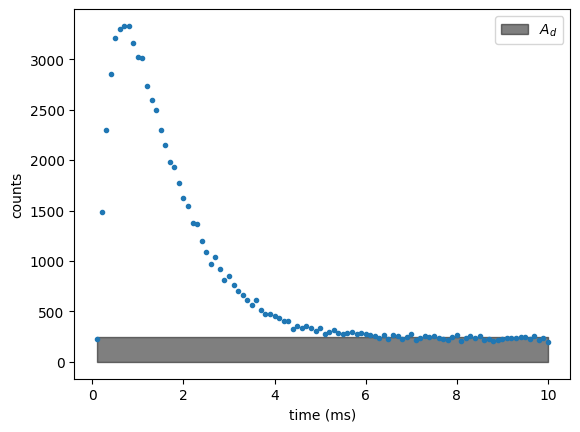

In [34]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.plot(T*1000,counts,'.')
plt.fill_between(T*1000, 250,color='black',alpha=0.5,label='$A_d$')
plt.xlabel('time (ms)')
plt.ylabel('counts')
plt.legend()
plt.show()

Now we will calculate the area under the curve for the prompt and the delayed contributions in order to estimate $\rho/\beta$. For this what you will need to do is:

1. Evaluate the area under the whole curve (ie. prompt+delayed). You can perform a numerical integration with the `np.trapz()` function. Remember you can see the documentation with `?np.trapz`. You can see that the first parameter is `y` (in our case `counts`), and the second parameter is `x` (in our case `T`).
2. Evaluate the delayed contribution. For this you can "fit" a constant to the tail. There are several ways to do this, one possibility is to take the `np.mean()` of the last few counts, and just multiply this value with the total measurement time.
3. Finally, from 1. and 2. you can calculate the prompt contribution.

If we assume that $\beta=0.0065$, we can calculate the k-eff.

In [35]:
beta=0.0065
rho=rhoDollar*beta
keff=1/(1-rho)

print(keff)

0.9840326974721897


As mentioned in the introduction we can find out $\Lambda/\beta$ also from this measurement, if we fit a function  

$$C_1\exp(\alpha t)+C_2$$

on the down falling part of the curve, we can obtain 

$$\frac{\Lambda}{\beta}=\frac{1}{\alpha}\Big(\frac{\rho}{\beta}-1\Big)$$

For curve fitting we are going to use the `curve_fit()` function of the `scipy.optimize` module. `curve_fit` works similarly as the other methods we used from scipy for root finding and ODE solving problems. One needs to give an other function as an input, and then the x and y datapoints we would like to fit on. If one had the uncertainties of the data points that could be also included. Thus a simple linear fit would look like the following:

```python
    xdata=[1,2,3,4]
    ydata=[1.9,4.1,5.7,8.5]

    def myFunc(x,a,b):
        return a*x+b

    p1,p2=curve_fit(myFunc,xdata,ydata) #p1[0] is coefficient a, p1[1] is coefficient b
```

But at this point it is important to highlight that there is a more pythonic way to achieve this by using a [lambda function](https://www.w3schools.com/python/python_lambda.asp). A lambda function is a small anonymous function, which only uses one expression. Let's see the equivalent of the previous code:

```python
    xdata=[1,2,3,4]
    ydata=[1.9,4.1,5.7,8.5]

    p1,p2=curve_fit(lambda x,a,b : a*x+b,xdata,ydata) #p1[0] is coefficient a, p1[1] is coefficient b
```

Isn't it beautiful? Besides of course that due to this `lambda` is a [reserved keyword](https://www.w3schools.com/python/python_ref_keywords.asp), which is sometimes painful, when we really feel like a variable should be called `lambda`.

But enough of talking, it is your turn now to perform a fit (either with a separate function or a lambda function), and estimate $\Lambda/\beta$! For this first you need to decide when does the exponential decreasing part begin?

In [ ]:
from scipy.optimize import curve_fit

p1,p2=#use curve_fit()


plt.figure()
plt.plot(T*1000,counts)
#plot the fit based on the coefficients in p1
plt.xlabel('time (ms)')
plt.ylabel('counts')
plt.show()


LambdaBeta=#Calculate Lambda/beta

print(LambdaBeta)

#just to check the order of magnitude of the generation time we can use our previous beta value here
print(LambdaBeta*beta)

## Experiment 2: Approaching criticality

When approaching criticality the operator can make a 1/M-plot to estimate how close to criticality the reactor is. In this exercise you will use data obtained at the [TRIGA](http://www.rcp.ijs.si/ric/index-a.htm) reactor of the Josef Stefan Institute in Ljubljana to do this. The reactor core has several positions, some of them filled with fuel, some of them filled with control assemblies.

The data includes the step changes in reactivity made by the operator (they know the reactivity change because they have tabulated reactivity worth curves of the control rods, so they know how much the reactivity changes by moving the control rod) and detector signals in counts per seconds from two detectors. The detectors are positioned at F8 and F27, respectively and the neutron source is situated at F9. After each step the operator calculates how far from criticality the reactor is. For the proceeding step the maximum allowed change in reactivity is half of what is left to reach criticality.

Just for fun why not draw the core map with matplotlib? Let's execute the script below. Each circle is a core position in the reactor.

In [ ]:
def rotate(x,y,a):
        a=a*(np.pi/180.0)
        xn=x*np.cos(a)-y*np.sin(a)
        yn=y*np.cos(a)+x*np.sin(a)
        return xn,yn

yshift=5.0
r=2.0
assyN=[1,6,12,18,24,30]
letter=['A','B','C','D','E','F']
fig, ax = plt.subplots(figsize=(8,8))
for i,N in enumerate(assyN):
    alpha=360/N
    x0=0.0
    ang=0.0
    y0=-i*yshift
    for j in range(N):
        x,y=rotate(x0,y0,ang)
        ang+=alpha
        circle = plt.Circle((x, y), r, color='lightgray')
        assyname=letter[i]+str(j+1)
        xnameshift = 1.3 if len(assyname)>2 else 0.9
        plt.annotate(assyname,(x-xnameshift,y-0.5))
        ax.add_artist(circle)
plt.xlim(-30,30)
plt.ylim(-30,30)
plt.xticks([])
plt.yticks([])
ax.patch.set_facecolor('aliceblue')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

And now let's load the data:

In [ ]:
Delta_rho = np.array([0,1539,3024,2331,2010,419])
F8 = np.array([7.93,8.75,12.06,16.27,46.3,81.83])
F27 = np.array([1.79,2.14,3.61,6.45,21.45,37.53])

We will first calculate the cumulative sum of the introduced reactivity with `np.cumsum`. Then we will normalize the detector counts to have 1.0 cps when the reactivity is zero.

Then we will use the `np.polyfit` function to fit a linear curve to the last two values of each normalized detector signal. In order to visualize the fit, we will evaluate it with the `np.poly1d` function. 

Read, complete and execute the code!

In [ ]:
rho = #use np.cumsum to get the cumulative sum of Delta_rho
Minv8= F8[0]/F8
Minv27=#normalize the signal detector 27

p8=np.polyfit(rho[-2:],Minv8[-2:], deg=1)
fit8=np.poly1d(p8)
p27=#fit a 1st degree polynom for detector 27
fit27=np.poly1d(p27)
rhofit=np.linspace(7000,11000,500)
plt.plot(rho,Minv8,'*', label='F8')
plt.plot(rho,Minv27,'.', label='F27')
plt.plot(rhofit,fit8(rhofit),'-')
plt.plot(rhofit,fit27(rhofit),'-')
plt.grid()
plt.legend()
plt.xlabel('Reactivity change / pcm')
plt.ylabel('1/M')
plt.show()

print('According to F8 criticality is reached by adding',round(-p8[1]/p8[0]-rho[-1]),'pcm')
print('According to F27 criticality is reached by adding',round(-p27[1]/p27[0]-rho[-1]),'pcm')

Now, let's go back in time a bit, and let's consider that the operator has not yet performed the last two reactivity insertion steps. Estimate from the detector counts how far is criticality? Which detector would you trust? What do you think, why do the detectors behave differently?

In [ ]:
Delta_rho = np.array([0,1539,3024,2331])
F8 = np.array([7.93,8.75,12.06,16.27])
F27 = np.array([1.79,2.14,3.61,6.45])

In [ ]:
#Your code comes here!

Change this line to your conclusion!

## Experiment 3: The Rossi-Alpha distribution (optional)

In a sub-critical system, neutrons will be produced due to effects such as spontaneous fission, induced fission, and due to other sources, such as (alpha,n) reactions in the material (the alpha particles emitted by the heavy nuclei can undergo such neutron producing reaction in the oxygen of the UO2 fuel). These neutrons can be detected, but it is not possible to determine the origin of the neutrons by only counting them. However, by studying the timing of the detected neutrons, more information about the origin of the neutrons can be determined. One frequently used method is based on the so-called Rossi-alpha distribution.

The basic idea behind the Rossi-alpha distribution is to look at every detected neutron, and for each such neutron look at when subsequent neutrons are detected. For uncorrelated neutrons, such as neutrons originating in different, independent spontaneous fission events, the time difference between the neutrons are random. However, if multiple neutrons originate from the same fission event, they will be correlated in time. Also, some of these neutrons could induce further fission, and the neutrons from the subsequent fission event are then time-correlated to any neutrons from the first event. 

To investigate Rossi-alpha distributions in this datalab, we first need to create a Monte-Carlo simulation of the detected neutrons. For simplicity, we will ignore ($\alpha$,n) reactions, and assume that any produced neutron can either induce a new fission, be detected, or be lost to other processes. The idea is to first sample random times when spontaneous fission events occur. Next, the number of emitted neutrons are sampled. For each neutron, we sample if it causes another fission (repeating the process), or if not, we sample if it is detected or not.

To sample the random times when sponteneous fissions occur, two methods can be used. The first is to note that within a certain time interval, the detection times are uniformly distributed in time. So if an average of $n$ neutrons are expected in a certain time, we can sample $n$ values from a uniform distribution and sort them, to obtain the detected neutron timings. The second is to note that for uncorrelated events, the time between two subsequent events is exponentially distributed. We will implement the second method.

We will assume that the time between the fission event and the detection of a neutron is also exponentially distributed. 

Each spontaneous fission neutron will induce further fissions with a probability $p$. We will model a system containing primarily U-235 as the fisslie isotope, so that the average number of neutrons per fission is about 2.43. Hence, we have approximately have $k = 2.43*p$, for the corresponding multiplication factor. The time between the initial fission and the induced fission is a bit more complicated to model, so for simplicity we will assume that this one is also exponentially distributed, with a different average time between events as compared to the spontanous fissions. 

Finally, the Monte-Carlo sampler will also include a detection efficiency, that samples if a neutron was detected or not. The simulation is implemented within the `MC_neutron()` function.

For the moment you just need to run the code block below.

In [ ]:
import numpy as np

def MC_neutron(measurement_time, spontaneous_rate, p, detection_time, fission_time, detector_efficiency):
    """Function to simulate the detection of neutrons from spontaneous and induced fission
    
    Parameters
    ----------
    measurement_time   : The length of the simulated detector response, in seconds
    spontaneous_rate   : rate of spontaneous fissions, in fissions/second
    k                  : probability that one spontaneous fission induces further fissions
    detection_time     : The mean time between a fission event and the detection of a neutron.
    fission_time       : average time between one fission and the subsequent induced fission, in microseconds
    detector_efficiency: probability that a fission event is detected
    """
    average_time = 1000000/spontaneous_rate # The average time between spontaneous fissions, in microseconds

    events = []

    time = 0 #Start the time at one spontaneous fission event. 
    maximum_time = detection_time*1000000 # convert to microseconds to match other times.

    #Add correlated neutrons to the list until we have covered the measurement time.
    while time < maximum_time:
        
        
        fission_event = []
        
        #First sample how long after the previous event a new spontaneous fission event occurs
        time = time + np.random.exponential(average_time)
        fission_event.append(time)

        while len(fission_event) > 0:
            
            #sample number of neutrons emitted, assuming U-235 fissions from thermal neutrons.
            nu=[0,1,2,3,4,5]
            pnu=[0.0296,0.1665,0.3427,0.2987,0.1275,0.035]
            nufiss=(nu,pnu)
            newBorn=np.random.choice(nufiss[0],p=nufiss[1])
            
            #for each neutron, sample if it induces fission, is detected, or is lost
            
            for i in range(0,newBorn):
                #Does a fission occur?
                induced_fission = np.random.binomial(1, p)
                if induced_fission == 1:
                    time_to_next_fission = fission_event[0] + np.random.exponential(fission_time)
                    if time_to_next_fission <= maximum_time:
                        fission_event.append(time_to_next_fission)
                    
                #If it did not induce fission, determine if it was detected or otherwise lost.
                detection = np.random.binomial(1, detector_efficiency)
                if induced_fission == 0 and detection == 1:
                    time_to_detection = fission_event[0] + np.random.exponential(detection_time)
                    if time_to_detection <= maximum_time:
                        events.append(time_to_detection)
            
            #We have finished simulating the fission event, so remove it from the list.
            del fission_event[0]

    # we may have out-of-order neutrons in the list
    # Sort the list, so that all time stamps are in order.
    
    events = sorted(events)
    return events


Now, let us begin by looking at a system with an spontaneous fission rate of 20000 fissions per second over 1 second, on average an induced fission occurs 5 $\mu$s after the intial event, and it takes 8 $\mu$s for a neutron to reach the detector. We  set $p=0.3$, so that each new neutron has a 30% probability to induce fission (note that each fission event produces on average 2.43 neutrons, so each fission event creates 0.3 * 2.43 = 0.729 new fission events). We also assume that 20% of neutrons that do not induce fission can be detected (the remining 80% are otherwise lost). We also plot the events from the first 2000 $\mu$s. For the plotting we use the `plt.stem` function.

In [ ]:
all_events = MC_neutron(1,20000,0.3,8,5,0.2)

import matplotlib.pyplot as plt

plt.figure()

plt.stem(all_events,[0.8]*len(all_events), 'g', markerfmt='go')
plt.xlabel("Time [us]")
plt.gca().axes.get_yaxis().set_visible(False)  
plt.xlim([0,1000])
plt.ylim([0,1])
plt.show()

From just a plot of detected neutrons, it is usually not easy to determine which neutrons are correlated, and which originate from a different event. For this specific case, we have set the time between a spontaneous and a subsequent induced fission to be shorter than the spontaneous fission rate, and the time for the neutrons to reach the detector is also shorter. So in this case, we can see clusters of multiple neutrons, which are likely to originate from the same spontaneous fission event. 

Next, let us make a function for converting the pulse train into a Rossi-alpha histogram. 

In [ ]:
import numpy as np

def Rossi_alpha(pulse_train, time_window, bins):
    """Function to convert a pulse train to a Rossi-Alpha histogram
    
    Parameters
    ----------
    pulse_train        : A list of event times
    time_window        : The time window to use 
    bins               : the number of bins to use in the histogram
    """
    time_differences = []

    for i in range(0,len(pulse_train)):
        #pulse_train[i] is now the initial neutron.
        j = i

        difference = 0
        while j < len(pulse_train) -1 and difference < time_window:
            #event_timings[j] is now a subsequent neutron. If it was detected within the time window,
            # add the time difference to the list of differences.
            j = j + 1
            difference = pulse_train[j] - pulse_train[i]
            if difference < time_window:
                time_differences.append(difference)
 

    histogram, bin_edges = np.histogram(time_differences, bins)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
    return bin_centers, histogram

Now, lets make a pulse train as above, and then produce and plot the Rossi-alpha distribution using a time window of 100 $\mu$s and 20 bins.

In [ ]:
all_events = MC_neutron(1,20000,0.3,3,5,0.2)
bin_centers, histogram = Rossi_alpha(all_events,100,20)




#Assume that the last five bins only contains accidentals
accidentals = np.average(histogram[-5:])

#Create polygons to show the accidentals and true coincidences.
coincidencePolycorners = []
for i in range(0,len(histogram)):
    coincidencePolycorners.append([bin_centers[i], histogram[i]])

coincidencePolycorners.append([bin_centers[-1], accidentals])
coincidencePolycorners.append([bin_centers[0], accidentals])

accidentalPolycorners=[[bin_centers[0],0],[bin_centers[0],accidentals],[bin_centers[-1], accidentals],[bin_centers[-1],0]]

#make a plot of the Rossi-alpha distribution.
plt.figure()
plt.scatter(bin_centers, histogram)
polygonC = plt.Polygon(coincidencePolycorners, True,color='red',alpha=0.2,hatch='/')
polygonA = plt.Polygon(accidentalPolycorners, True,color='green',alpha=0.2,hatch='\\')
plt.gca().add_artist(polygonC)
plt.text(0,accidentals*1.1,'True \n coincidences:',color='r')
plt.gca().add_artist(polygonA)
plt.text(0,accidentals*0.45,'Accidental \n coincidences',color='green')
plt.ylim([0,max(histogram)*1.2])
plt.xlabel("Time [us]")
plt.ylabel("Frequency [counts]")
plt.axhline(accidentals, color='black')
plt.title("Rossi-alpha distribution")
plt.show()
                                     

It is your time now to play a bit!

### Experiment 3.1

Make a Rossi-alpha distribution for systems with fission probabilities per neutron ranging from 0 to 0.3. How do you think the distribution will change with multiplication?

In [ ]:
# your code comes here

### Experiment 3.2

Make Rossi-alpha distributions for  a fissile system where the spontaneous fission rate is on the order of the time it takes neutrons to reach the detector, or shorter. Can you still see any true coincidences in the histograms?

In [ ]:
# your code comes here

### Experiment 3.3

Decrease the detector efficiency below 20%. Can we still detect correlated neutrons if the detection probability is very low? (Note that in practice a large efficiency can be achieved by putting more detectors around the fissile material)

In [ ]:
# your code comes here

### Experiment 3.4:

For the Rossi-alpha distirbution simulated in the example above, make an exponential fit to the curve of the form $Ae^{-t/\tau}$, and determine $\tau$.

In [ ]:
# your code comes here